In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [16]:
data = pd.read_csv("lamoda_reviews.csv")

In [17]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if 2*x >= 7 else 0)

In [18]:
data

,Name,Description,Review,Rating,Sentiment
0,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Отличные кроссовки, очень лёгкие, на ножке акк...",5,1
1,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Красивые, стильные, удобные.",5,1
2,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Все хорошо. Идет в размер,5,1
3,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Удобные и красивые, но вся грязь собирается на...",4,1
4,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Удобные пока не носоли.,5,1
...,...,...,...,...,...
112460,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,"Легкие, удобные",5,1
112461,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,"В размер,удобные,взяла на море.Запах конечно ж...",3,0
112462,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,Шлёпанцы огонь ! Брала месяц назад на море в т...,5,1
112463,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,Шлепки хороши!,5,1


# SVM

In [19]:
data_clean = data.copy()

In [20]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(lambda x: count_russian_chars(str(x)))

In [21]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [22]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))
print(data_clean_russian.head())

                        Name  \
0  Кроссовки NIKE AIR MAX SC   
1  Кроссовки NIKE AIR MAX SC   
2  Кроссовки NIKE AIR MAX SC   
3  Кроссовки NIKE AIR MAX SC   
4  Кроссовки NIKE AIR MAX SC   

                                         Description  \
0  Кроссовки выполнены из натуральной кожи с текс...   
1  Кроссовки выполнены из натуральной кожи с текс...   
2  Кроссовки выполнены из натуральной кожи с текс...   
3  Кроссовки выполнены из натуральной кожи с текс...   
4  Кроссовки выполнены из натуральной кожи с текс...   

                                              Review  Rating  Sentiment  \
0  отличн кроссовк очен легк на ножк аккуратн смо...       5          1   
1                                красив стильн удобн       5          1   
2                            все хорош идет в размер       5          1   
3  удобн и красив но вся гряз собира на подошв и ...       4          1   
4                                 удобн пок не носол       5          1   

   Russian chars  


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [25]:
pipeline = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', SVC(C=1, kernel='linear'))
])

In [26]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SVC(C=1, kernel='linear'))])

In [27]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      1459
           1       0.97      0.99      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.86      0.76      0.80     26195
weighted avg       0.96      0.96      0.96     26195



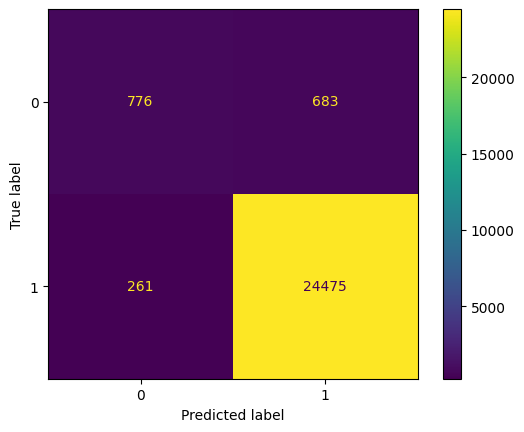

In [28]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

Добавим немного экспериментов с параметрами! Попробуем перейти на другое ядро - rbf, а также поиграться с параметром C.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

C = 1
              precision    recall  f1-score   support

           0       0.84      0.38      0.52      1459
           1       0.96      1.00      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.90      0.69      0.75     26195
weighted avg       0.96      0.96      0.95     26195



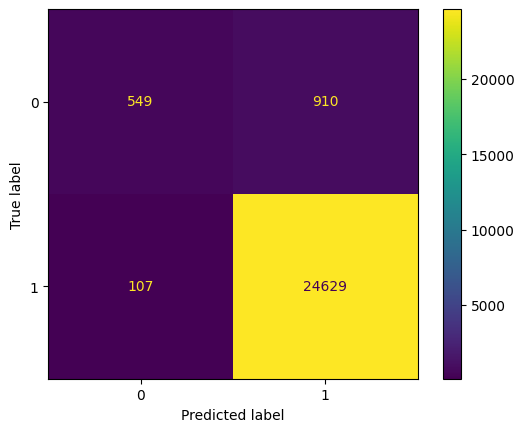

In [30]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=1, kernel="rbf"))
])

print('='*50)
print("C = 1")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

C = 10
              precision    recall  f1-score   support

           0       0.77      0.51      0.61      1459
           1       0.97      0.99      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.87      0.75      0.80     26195
weighted avg       0.96      0.96      0.96     26195



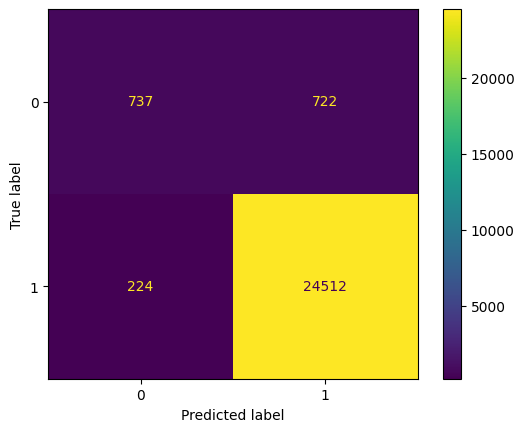

In [31]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=10, kernel="rbf"))
])

print('='*50)
print("C = 10")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

# Итоги

## Linear kernel

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      1459
           1       0.97      0.99      0.98     24736

## RBF kernel

* C = 1

              precision    recall  f1-score   support

           0       0.84      0.38      0.52      1459
           1       0.96      1.00      0.98     24736

* C = 10

              precision    recall  f1-score   support

           0       0.77      0.51      0.61      1459
           1       0.97      0.99      0.98     24736